In [5]:
import os

import cv2

import warnings
import collections
from glob import glob
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


from torchvision.models import vit_b_16
from torchvision.ops.feature_pyramid_network import (
    LastLevelMaxPool,
)
from torchvision.ops.feature_pyramid_network import (
    FeaturePyramidNetwork
)

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

from tensorboardX import SummaryWriter


warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
root = "/Volumes/S/dev/project/code/instance_metric1/prep"
root_depth = '/Volumes/S/dev/project/code/instance_metric1/depth/'

In [8]:
glob(os.path.join(root, 'leftImg8bit', 'train', '*.png'))[0], glob(os.path.join(root, 'gtFineI', 'train', '*instanceIds.png'))[0] , glob(os.path.join(root_depth, 'depth', 'train', '*.png'))[0] 

('/Volumes/S/dev/project/code/instance_metric1/prep/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png',
 '/Volumes/S/dev/project/code/instance_metric1/prep/gtFineI/train/aachen_000000_000019_gtFine_instanceIds.png',
 '/Volumes/S/dev/project/code/instance_metric1/depth/depth/train/aachen_000000_000019_depth.png')

# Lables

In [9]:
from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#  dictionaries for a fast lookup

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

In [10]:
# Print all the labels
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval' ))
print("    " + ('-' * 98))
for label in labels:
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval ))
print("")

print("Example usages:")

# Map from name to label
name = 'car'
id   = name2label[name].id
print("ID of label '{name}': {id}".format( name=name, id=id ))

# Map from ID to label
category = id2label[id].category
print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

# Map from trainID to label
trainId = 0
name = trainId2label[trainId].name
print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |      19 |           void |          0 |            0 |            1
              ego vehicle |   1 |      19 |           void |          0 |            0 |            1
     rectification border |   2 |      19 |           void |          0 |            0 |            1
               out of roi |   3 |      19 |           void |          0 |            0 |            1
                   static |   4 |      19 |           void |          0 |            0 |            1
                  dynamic |   5 |      19 |           void |          0 |            0 |            1
                   ground |   6 |      19 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [11]:
def compute_depth(disparity : np.ndarray, 
                  w : int = 2048, 
                  h : int = 1024, 
                  inpaint_radius : int = None, 
                  baseline : float = 0.209313, 
                  f : float = 2262.52, 
                  max_depth : int = 500) -> np.ndarray:
    """ Computes smooth depth map from disparity 
        Inputs:
            disparity - uint16 dispairty image, 
            w - disparity width, 
            h - disparity height, 
            inpaint_radius - inpainting radius, 
            baseline stereo baseline distance (meters), 
            f - camera focal length (pixels) 
                For CityScapes:
                    fx = 2262.52 
                    fy = 2265.3017905988554 
            max_depth - maximum valid depth (meters)
        Outputs: 
            depth - computed depth map
        """
    
    """ NOTE: For training, need to process all input images just like this! """
    # crop noisy areas and resize
    disparity = cv2.resize(disparity[50:int(h*0.8), 100:], (w,h))

    # inpaint invalid disparity
    if inpaint_radius:
        disparity = cv2.inpaint(disparity, 
                                np.uint8(255*(disparity <= 1)), 
                                inpaintRadius=inpaint_radius, 
                                flags=cv2.INPAINT_TELEA)

    # blur to reduce noise
    disparity = cv2.medianBlur(disparity, 5)

    # scale to get True Disparity
    disparity = disparity.astype(np.float32)
    disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

    # compute depth
    depth = baseline * f / (disparity + 0.1)

    # clip and return
    return np.clip(depth, 0, max_depth)

# Depth Coversion

In [12]:
class CityScapes():
    def __init__(self, root, split='train', return_paths=False):
        self.root = root
        self.return_paths = return_paths

        self.rgb_paths = sorted(glob(os.path.join(root, 'leftImg8bit', split, '*.png')))
        self.mask_paths = sorted(glob(os.path.join(root, 'gtFineI', split, '*instanceIds.png')))
        # self.mask_paths = glob(os.path.join(root, 'gtFineS', split, '**\*labelIds.png'))
        self.disparity_paths = sorted(glob(os.path.join(root_depth, 'disparity', split, '*.png')))


    def __getitem__(self, idx):
        rgb_image = cv2.cvtColor(cv2.imread(self.rgb_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED)
        disparity = cv2.imread(self.disparity_paths[idx], cv2.IMREAD_UNCHANGED)

        if self.return_paths:
            return rgb_image, (mask, disparity), self.rgb_paths[idx], (self.mask_paths[idx], self.disparity_paths[idx])

        return rgb_image, (mask, disparity)
    
    def __len__(self):
        return len(self.rgb_paths)

In [14]:
for split in ( 'val', 'test'):
    # create dir for split
    # print(split)
    split_dir = os.path.join(root_depth, split)
    if not os.path.exists(split_dir):
        os.mkdir(split_dir)

    # get dataset
    dataset = CityScapes(root, split=split, return_paths=True)

    # get depth map for all disparities
    for i in range(len(dataset)):
        _, (_, disparity), _, (_, disparity_path) = dataset[i]
        # print("disparity_path: ",disparity_path)
        depth = compute_depth(disparity)

        savepath = disparity_path.replace('disparity', 'depth')
        dirname, _= os.path.split(savepath)
        # print("dirname: ",dirname)
        if not os.path.exists(dirname):
            os.mkdir(dirname)

        cv2.imwrite(savepath, depth)


# Dataset

In [15]:
# sorted(glob(os.path.join(root, 'gtFineP', 'train', '*_polygons.json')))

In [16]:
# Add 100 to 'static' in label_to_trainId
label_to_trainId = {label.name: label.trainId for label in labels}
label_to_trainId["static"] += 100

def process_target(annotation):
    """
    Processes a single annotation dictionary to prepare targets compatible with Mask R-CNN.
    
    Args:
        annotation: Dictionary containing "objects", "imgHeight", and "imgWidth".

    Returns:
        Dictionary containing 'boxes', 'labels', and 'masks' as PyTorch tensors.
    """
    bboxes = []
    valid_labels = []
    masks = []
    
    for obj in annotation["objects"]:
        # Get bounding box
        polygon = np.array(obj["polygon"])
        x_min, y_min = polygon.min(axis=0)
        x_max, y_max = polygon.max(axis=0)
        bboxes.append([x_min, y_min, x_max, y_max])
        
        # Map labels to train IDs
        label = obj["label"]
        if label in label_to_trainId:
            valid_labels.append(label_to_trainId[label])
        else:
            continue  # Skip invalid labels

        # Generate binary mask from polygon
        mask = np.zeros((annotation["imgHeight"], annotation["imgWidth"]), dtype=np.uint8)
        cv2.fillPoly(mask, [polygon.astype(np.int32)], color=1)
        masks.append(mask)
    for i in range(300):
        valid_labels.append(label_to_trainId['static'])

    # Prepare target dictionary
    target = {
        "boxes": torch.tensor(bboxes, dtype=torch.float32).to(DEVICE),
        "labels": torch.tensor(valid_labels, dtype=torch.int64).to(DEVICE),
        "masks": torch.tensor(masks, dtype=torch.uint8).to(DEVICE),
    }
    
    return target


In [17]:
class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, split='train', label_map='id', crop=True):
        self.root = root
        self.transform = transform
        self.label_map = label_map
        self.crop = crop

        self.left_paths = sorted(glob(os.path.join(root, 'leftImg8bit', split, '*.png')))
        self.mask_paths = sorted(glob(os.path.join(root, 'gtFine', split, '*.png')))
        self.depth_paths = sorted(glob(os.path.join(root_depth, 'depth', split, '*.png')))
        
        print(self.left_paths[0])
        print(self.mask_paths[0])
        print(self.depth_paths[0])
        # get label mappings
        self.id_2_train = {}
        self.id_2_cat = {}
        self.train_2_id = {}
        self.id_2_name = {-1 : 'unlabeled'}
        self.trainid_2_name = {19 : 'unlabeled'} # {255 : 'unlabeled', -1 : 'unlabeled'}

        for lbl in labels:
            self.id_2_train.update({lbl.id : lbl.trainId})
            self.id_2_cat.update({lbl.id : lbl.categoryId})
            if lbl.trainId != 19: # (lbl.trainId > 0) and (lbl.trainId != 255):
                self.trainid_2_name.update({lbl.trainId : lbl.name})
                self.train_2_id.update({lbl.trainId : lbl.id})
            if lbl.id > 0:
                self.id_2_name.update({lbl.id : lbl.name})


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.uint8)
        depth =  cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.float32)
        # depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.uint8)
        # depth = np.load(self.depth_paths[idx]) # data is type float16
        # Retrieve corresponding annotation


        
        if self.crop:
            left = left[:800, :, :]
            mask = mask[:800, :]
            depth = depth[:800, :]

        # get label id
        if self.label_map == 'id':
            mask[mask==-1] == 0
        elif self.label_map == 'trainId':
            for _id, train_id in self.id_2_train.items():
                mask[mask==_id] = train_id
        elif self.label_map == 'categoryId':
            for _id, train_id in self.id_2_cat.items():
                mask[mask==_id] = train_id

        sample = {'left' : left, 'mask' : mask, 'depth' : depth}

        if self.transform:
            sample = self.transform(sample)

        # ensure that no depth values are less than 0
        depth[depth < 0] = 0

        return sample
    

    def __len__(self):
        return len(self.left_paths)

In [18]:
dataset = CityScapesDataset(root, split='train')

/Volumes/S/dev/project/code/instance_metric1/prep/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png
/Volumes/S/dev/project/code/instance_metric1/prep/gtFine/train/aachen_000000_000019_gtFine_labelIds.png
/Volumes/S/dev/project/code/instance_metric1/depth/depth/train/aachen_000000_000019_depth.png


In [19]:
sample = dataset.__getitem__(198)

In [20]:
# sample = dataset.__getitem__(198)
# sample['target']
"""
{'boxes': tensor([[   0.,  277., 2047., 1023.],
         [1223.,  397., 2047.,  574.],
         [1251.,  440., 2047.,  636.],
         [ 741.,  415., 1124.,  436.],
         [   0.,  481.,  354.,  547.],
         [   0.,  389.,  618.,  526.],
         [ 292.,    0., 1253.,  400.],
         [ 507.,  136., 1509.,  437.],
         [ 378.,  163.,  496.,  315.],
         [ 648.,  405.,  669.,  420.],
         [1390.,  362., 1399.,  381.],
         [ 849.,  346.,  858.,  416.],
         [ 479.,    0., 1435.,  430.],
         [1367.,    0., 2047.,  484.],
         [ 538.,  393.,  597.,  425.],
         [   0.,    0.,  550.,  512.],
         [ 807.,  276.,  826.,  313.],
         [ 894.,  357.,  922.,  381.],
         [ 814.,  290.,  912.,  404.],
         [ 965.,  363.,  972.,  410.],
         [ 936.,  324.,  988.,  373.],
         [ 761.,  425.,  968.,  447.],
         [ 941.,  399.,  987.,  426.],
         [ 699.,  418.,  965.,  441.],
         [ 862.,  382.,  928.,  436.],
         [ 678.,  405.,  706.,  423.],
         [ 924.,  398.,  940.,  415.],
         [ 927.,  414.,  939.,  435.],
         [ 673.,  414.,  712.,  446.],
         [ 558.,  366.,  578.,  378.],
         [ 644.,  416.,  698.,  453.],
         [ 559.,  249.,  573.,  415.],
         [ 472.,  403.,  607.,  452.],
         [ 464.,  436.,  606.,  456.],
         [ 563.,  377.,  576.,  390.],
         [ 576.,  373.,  582.,  456.],
         [ 690.,  293.,  708.,  329.],
         [ 593.,  349.,  602.,  353.],
         [ 587.,  354.,  609.,  375.],
         [ 595.,  297.,  700.,  454.],
         [ 261.,  438.,  353.,  505.],
         [   0.,  195.,  113.,  513.],
         [  22.,  467.,   89.,  515.],
         [   0.,  492.,  125.,  537.],
         [   0.,  465.,  853., 1023.],
         [  70.,    0.,  142.,   38.],
         [ 147.,    0.,  975.,  523.],
         [   0.,  444.,  849.,  887.],
         [ 769.,  233.,  911.,  402.],
         [ 898.,  215.,  927.,  271.],
         [ 771.,  348.,  799.,  383.],
         [ 752.,  349.,  771.,  375.],
         [ 706.,  377.,  807.,  455.],
         [1004.,  395., 1058.,  427.],
         [1061.,  395., 1113.,  429.],
         [ 991.,  406., 1092.,  490.],
         [1095.,  376., 1183.,  442.],
         [1202.,  400., 1356.,  429.],
         [1138.,  303., 1226.,  411.],
         [1146.,  363., 1155.,  383.],
         [1153.,  351., 1158.,  427.],
         [1148.,  362., 1156.,  371.],
         [1231.,  264., 1242.,  427.],
         [1223.,  358., 1239.,  418.],
         [1143.,  404., 1216.,  474.],
         [1269.,  428., 1273.,  460.],
         [1158.,  409., 1275.,  485.],
         [1107.,  230., 1281.,  464.],
         [1092.,  222., 1120.,  279.],
         [1259.,  309., 1291.,  341.],
         [1266.,  298., 1282.,  307.],
         [1259.,  342., 1276.,  374.],
         [1270.,  343., 1281.,  377.],
         [1290.,  389., 1308.,  422.],
         [1303.,  393., 1317.,  431.],
         [1289.,  415., 1349.,  465.],
         [1317.,  404., 1447.,  483.],
         [1433.,  395., 1619.,  504.],
         [1806.,    0., 1845.,  414.],
         [1797.,  277., 1862.,  304.],
         [1608.,  379., 1915.,  551.],
         [1787.,  440., 1855.,  458.],
         [1534.,  439., 1577.,  449.],
         [1383.,  435., 1413.,  443.],
         [1214.,  441., 1241.,  449.],
         [1031.,  440., 1060.,  448.],
         [  24.,  796., 2047., 1023.],
         [ 416.,    0., 2047.,   28.],
         [2037.,  509., 2047., 1023.],
         [   0.,    0.,   17.,  474.],
         [   0.,  977., 1937., 1023.],
         [   0.,    0., 2048., 1024.]], device='cuda:0'),
 'labels': tensor([  0,   1,  19,   1,  19,   1,  10,   2,   8,  13,   6,   5,   8,   2,
           8,   2,   6,   6,   5,   5,   7,  19,  13,   9,   8,  13,   7,   7,
          13, 119,  13,   5,   8,   9, 119,   5,   6, 119, 119,   5,  13,   8,
         119,   9,  19,   8,   8,   9,   5,   6,   6,   6,   8,  13,  13,  13,
           9,   9, 119,   6,   5,   6,   5,   5,  13,   5,  13,   5,   6,   7,
           7,   6,   6, 119, 119,  17,  13,  13,   5, 119,  13,  19,  19,  19,
          19,  19,  19,  19,  19,  19,  19,  19, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
         119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119],
        device='cuda:0'),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0', dtype=torch.uint8)}
"""


"\n{'boxes': tensor([[   0.,  277., 2047., 1023.],\n         [1223.,  397., 2047.,  574.],\n         [1251.,  440., 2047.,  636.],\n         [ 741.,  415., 1124.,  436.],\n         [   0.,  481.,  354.,  547.],\n         [   0.,  389.,  618.,  526.],\n         [ 292.,    0., 1253.,  400.],\n         [ 507.,  136., 1509.,  437.],\n         [ 378.,  163.,  496.,  315.],\n         [ 648.,  405.,  669.,  420.],\n         [1390.,  362., 1399.,  381.],\n         [ 849.,  346.,  858.,  416.],\n         [ 479.,    0., 1435.,  430.],\n         [1367.,    0., 2047.,  484.],\n         [ 538.,  393.,  597.,  425.],\n         [   0.,    0.,  550.,  512.],\n         [ 807.,  276.,  826.,  313.],\n         [ 894.,  357.,  922.,  381.],\n         [ 814.,  290.,  912.,  404.],\n         [ 965.,  363.,  972.,  410.],\n         [ 936.,  324.,  988.,  373.],\n         [ 761.,  425.,  968.,  447.],\n         [ 941.,  399.,  987.,  426.],\n         [ 699.,  418.,  965.,  441.],\n         [ 862.,  382.,  928

In [21]:
"""for i, tvalue in enumerate(dataset):
    tvalue = tvalue['target']
    masks, boxes = tvalue['boxes'], tvalue['labels']
    num_masks = len(masks)
    num_boxes = len(boxes)
    print(f"Image {i}: Masks = {num_masks}, Boxes = {num_boxes}")
    assert num_masks == num_boxes, f"Mismatch: {num_masks} masks and {num_boxes} boxes"
"""

'for i, tvalue in enumerate(dataset):\n    tvalue = tvalue[\'target\']\n    masks, boxes = tvalue[\'boxes\'], tvalue[\'labels\']\n    num_masks = len(masks)\n    num_boxes = len(boxes)\n    print(f"Image {i}: Masks = {num_masks}, Boxes = {num_boxes}")\n    assert num_masks == num_boxes, f"Mismatch: {num_masks} masks and {num_boxes} boxes"\n'

In [22]:
sample['left'].shape, sample['mask'].shape, sample['depth'].shape

((800, 2048, 3), (800, 2048), (800, 2048))

In [23]:
"""
# rgb_image, mask, disparity = dataset.__getitem__(130)
sample = dataset.__getitem__(198)

_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(sample['left'])
ax[1].imshow(sample['mask'], cmap='nipy_spectral')
ax[2].imshow(sample['depth'], cmap='plasma')
"""

"\n# rgb_image, mask, disparity = dataset.__getitem__(130)\nsample = dataset.__getitem__(198)\n\n_, ax = plt.subplots(1, 3, figsize=(20, 8))\nax[0].imshow(sample['left'])\nax[1].imshow(sample['mask'], cmap='nipy_spectral')\nax[2].imshow(sample['depth'], cmap='plasma')\n"

In [24]:
"""
unique_ids = torch.unique(sample['mask'])
print("Unique Object IDs:", unique_ids)
"""
"""
Unique Object IDs: [  0   1   2   3   4   6   7   8   9  11  17  19  20  21  22  23 144 145
 146 147 148 149 150 151 152 153 154 155 156 157]
"""

'\nUnique Object IDs: [  0   1   2   3   4   6   7   8   9  11  17  19  20  21  22  23 144 145\n 146 147 148 149 150 151 152 153 154 155 156 157]\n'

In [25]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
# from albumentations.augmentations.transforms import RandomShadow

class Normalize(object):
    """ Normalizes RGB image to  0-mean 1-std_dev """ 
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], depth_norm=5, max_depth=250):
        self.mean = mean
        self.std = std
        self.depth_norm = depth_norm
        self.max_depth = max_depth

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
            
        return {'left': TF.normalize(left, self.mean, self.std), 
                'mask': TF.normalize(mask.float(), self.mean, self.std), 
                'depth' : torch.clip( # saftey clip :)
                            torch.log(torch.clip(depth, 0, self.max_depth))/self.depth_norm, 
                            0, 
                            self.max_depth),
               }


class AddColorJitter(object):
    """Convert a color image to grayscale and normalize the color range to [0,1].""" 
    def __init__(self, brightness, contrast, saturation, hue):
        ''' Applies brightness, constrast, saturation, and hue jitter to image ''' 
        self.color_jitter = transforms.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        return {'left': self.color_jitter(left), 
                'mask': mask, 
                'depth' : depth}


class Rescale(object):
    """ Rescales images with bilinear interpolation and masks with nearest interpolation """

    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        

        # Rescale left image
        left = TF.resize(left, (self.h, self.w))
        
        # Rescale mask with nearest neighbor interpolation
        mask = TF.resize(mask.unsqueeze(0), (self.h, self.w), transforms.InterpolationMode.NEAREST).squeeze(0)
        
        # Rescale depth
        depth = TF.resize(depth.unsqueeze(0), (self.h, self.w)).squeeze(0)

        return {
            'left': left,
            'mask': mask,
            'depth': depth,
        }


class RandomCrop(object):
    def __init__(self, h, w, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)):
        self.h = h
        self.w = w
        self.scale = scale
        self.ratio = ratio

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        i, j, h, w = transforms.RandomResizedCrop.get_params(left, scale=self.scale, ratio=self.ratio)

        return {'left': TF.resized_crop(left, i, j, h, w, (self.h, self.w)), 
                'mask': TF.resized_crop(mask.unsqueeze(0), i, j, h, w, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST),
                'depth' : TF.resized_crop(depth.unsqueeze(0), i, j, h, w, (self.h, self.w))}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
         
        left, mask, depth= sample['left'], sample['mask'], sample['depth']

        return {'left': transforms.ToTensor()(left), 
                'mask': torch.as_tensor(mask, dtype=torch.int64),
                'depth' : transforms.ToTensor()(depth).type(torch.float32),
               }
    

class ElasticTransform(object):
    def __init__(self, alpha=25.0, sigma=5.0, prob=0.5):
        self.alpha = [1.0, alpha]
        self.sigma = [1, sigma]
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:

            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            _, H, W = mask.shape
            displacement = transforms.ElasticTransform.get_params(self.alpha, self.sigma, [H, W])

            # # TEMP
            # print(TF.elastic_transform(left, displacement).shape)
            # print(TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST).shape)
            # print(torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max()).shape)

            return {'left': TF.elastic_transform(left, displacement), 
                    'mask': TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST), 
                    'depth' : torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max())} 
        
        else:
            return sample

        
    

# new transform to rotate the images
class RandomRotate(object):
    def __init__(self, angle):
        if not isinstance(angle, (list, tuple)):
            self.angle = (-abs(angle), abs(angle))
        else:
            self.angle = angle

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        angle = transforms.RandomRotation.get_params(self.angle)

        return {'left': TF.rotate(left, angle), 
                'mask': TF.rotate(mask.unsqueeze(0), angle), 
                'depth' : TF.rotate(depth, angle)}
    
    
class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.hflip(left), 
                    'mask': TF.hflip(mask), 
                    'depth' : TF.hflip(depth)}
        else:
            return sample
        

class RandomVerticalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.vflip(left), 
                    'mask': TF.vflip(mask), 
                    'depth' : TF.vflip(depth)}
        else:
            return sample

In [26]:
BATCH_SIZE = 4
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [27]:
OG_W, OG_H = 2048, 800 # OG width and height after crop
W, H = int(OG_W//9.14), int(OG_H//3.57) # resize w,h for training

# transform = transforms.Compose([
#     ToTensor(),
#     RandomCrop(H, W),
#     # ElasticTransform(alpha=100.0, sigma=25.0, prob=0.5),
#     AddColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#     RandomHorizontalFlip(0.5),
#     RandomVerticalFlip(0.2),
#     # RandomRotate((-30, 30)),
#     Normalize()
# ])

transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    # Normalize()
])


valid_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    # Normalize()
])

test_transform = transforms.Compose([
    ToTensor(),
    # Normalize()
])

def custom_collate_fn(batch):
#     """
#     Handles batches with variable-sized bounding boxes.
#     """
     images = torch.stack([item['left'] for item in batch])  # Stack images
     masks = torch.stack([item['mask'] for item in batch])  # Stack masks
     depths = torch.stack([item['depth'] for item in batch])  # Stack depths
    
    
     return {'left': images, 'mask': masks, 'depth': depths}

train_dataset = CityScapesDataset(root, transform=transform, split='train', label_map='trainId') # 'trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)

# temp_valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId', crop=False)
valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)

test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)

/Volumes/S/dev/project/code/instance_metric1/prep/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png
/Volumes/S/dev/project/code/instance_metric1/prep/gtFine/train/aachen_000000_000019_gtFine_labelIds.png
/Volumes/S/dev/project/code/instance_metric1/depth/depth/train/aachen_000000_000019_depth.png
/Volumes/S/dev/project/code/instance_metric1/prep/leftImg8bit/val/frankfurt_000000_000294_leftImg8bit.png
/Volumes/S/dev/project/code/instance_metric1/prep/gtFine/val/frankfurt_000000_000294_gtFine_labelIds.png
/Volumes/S/dev/project/code/instance_metric1/depth/depth/val/frankfurt_000000_000294_depth.png
/Volumes/S/dev/project/code/instance_metric1/prep/leftImg8bit/test/berlin_000000_000019_leftImg8bit.png
/Volumes/S/dev/project/code/instance_metric1/prep/gtFine/test/berlin_000000_000019_gtFine_labelIds.png
/Volumes/S/dev/project/code/instance_metric1/depth/depth/test/berlin_000000_000019_depth.png


In [28]:
# # Save processed dataset
# torch.save(train_dataset, "train_dataset.pt")
# torch.save(valid_dataset, "valid_dataset.pt")
# torch.save(test_dataset, "test_dataset.pt")

In [29]:
# # Load preprocessed dataset
# train_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/train_dataset.pt")
# valid_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/valid_dataset.pt")
# test_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/test_dataset.pt")

# # Recreate data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
# valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)


In [30]:
NUM_SEG_CLASSES = len(train_dataset.trainid_2_name)
print(train_dataset.trainid_2_name)
NUM_SEG_CLASSES

{19: 'unlabeled', 0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}


20

In [31]:
NUM_CLASSES = NUM_SEG_CLASSES

In [32]:
name_2_trainid = {v: k for k, v in train_dataset.trainid_2_name.items()}

In [33]:
def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    """
    Generate a color mask for instance segmentation.
    
    Args:
        mask (np.ndarray): 2D array with unique IDs for each instance or class.
        labels (list): List of label objects containing `id`, `trainId`, and `color`.
        id_type (str): Type of ID to match ('id' or 'trainId').
        
    Returns:
        np.ndarray: 3D color mask with shape (H, W, 3).
    """
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    # Initialize the color mask
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # Map instance or class IDs to colors
    unique_ids = torch.unique(mask)  # Get unique IDs in the mask
    instance_colors = {}  # To store unique colors for each instance

    if id_type == 'id':
        for instance_id in unique_ids:
            # Find corresponding label in the provided list
            label = next((lbl for lbl in labels if lbl.id == instance_id), None)
            if label:
                color = label.color
            else:
                # Generate random color for unmatched instances (e.g., unlabelled objects)
                if instance_id not in instance_colors:
                    instance_colors[instance_id] = tuple(np.random.randint(0, 256, 3).tolist())
                color = instance_colors[instance_id]

            color_mask[mask == instance_id] = color

    elif id_type == 'trainId':
        for instance_id in unique_ids:
            # Skip invalid train IDs
            if instance_id in [255, -1]:
                continue

            label = next((lbl for lbl in labels if lbl.trainId == instance_id), None)
            if label:
                color = label.color
            else:
                # Generate random color for unmatched instances
                if instance_id not in instance_colors:
                    instance_colors[instance_id] = tuple(np.random.randint(0, 256, 3).tolist())
                color = instance_colors[instance_id]

            color_mask[mask == instance_id] = color

    return color_mask



def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='plasma')
    ax[2].set_title("Depth")

# Training 

In [34]:
NUM_LAYER = 12
PATCH_SIZE = 16
HIDDEN_DIM = 768
MAX_EPOCH = 100
BATCH_SIZE = 4
IMG_SIZE = 224

In [35]:
"""
NUM_LAYER = 12
PATCH_SIZE = 16
HIDDEN_DIM = 768
NUM_CLASSES = 2
IMG_SIZE = 224
INFERENCE_SAMPLE = 3
THRESHOLD_DETECTION = 0.75
THRESHOLD_SEGMENTATION = 0.5
MAX_EPOCH               = 100
BATCH_SIZE              = 16
EARLY_STOPPING_PATIENCE = 35
LEARNING_RATE    = 0.015 * (math.pi / math.e)
MOMENTUM         = 0.1 * (math.pi * math.e)
WEIGHT_DECAY     = 8 * (math.pi + math.e)
REDUCE_LR_FACTOR = 1.15 * (math.pi - math.e)
"""

'\nNUM_LAYER = 12\nPATCH_SIZE = 16\nHIDDEN_DIM = 768\nNUM_CLASSES = 2\nIMG_SIZE = 224\nINFERENCE_SAMPLE = 3\nTHRESHOLD_DETECTION = 0.75\nTHRESHOLD_SEGMENTATION = 0.5\nMAX_EPOCH               = 100\nBATCH_SIZE              = 16\nEARLY_STOPPING_PATIENCE = 35\nLEARNING_RATE    = 0.015 * (math.pi / math.e)\nMOMENTUM         = 0.1 * (math.pi * math.e)\nWEIGHT_DECAY     = 8 * (math.pi + math.e)\nREDUCE_LR_FACTOR = 1.15 * (math.pi - math.e)\n'

In [36]:
import os
import cv2
import sys
import time
import numpy as np

import torch

# _, term_width = os.popen('stty size', 'r').read().split()
term_width = 2

TOTAL_BAR_LENGTH = 30.
last_time = time.time()
begin_time = last_time


def progress_bar(current, total, epochs, cur_epoch, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH * current / total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time
    remain_time = step_time * (total - current) + \
        (epochs - cur_epoch) * step_time * total

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    L.append(' | Rem: %s' % format_time(remain_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width - int(TOTAL_BAR_LENGTH) - len(msg) - 3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width - int(TOTAL_BAR_LENGTH / 2) + 2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current + 1, total))

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


class AverageMeter():
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes).zfill(2) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf).zfill(2) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis).zfill(3) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


def display_result(result_dict):
    line = "\n"
    line += "=" * 100 + '\n'
    for metric, value in result_dict.items():
        line += "{:>10} ".format(metric)
    line += "\n"
    for metric, value in result_dict.items():
        line += "{:10.4f} ".format(value)
    line += "\n"
    line += "=" * 100 + '\n'

    return line
    

def save_images(pred, save_path):
    if len(pred.shape) > 3:
        pred = pred.squeeze()

    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().numpy().astype(np.uint8)

    if pred.shape[0] < 4:
        pred = np.transpose(pred, (1, 2, 0))
    cv2.imwrite(save_path, pred, [cv2.IMWRITE_PNG_COMPRESSION, 0])


def check_and_make_dirs(paths):
    if not isinstance(paths, list):
        paths = [paths]
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

def log_args_to_txt(log_txt, args):
    if not os.path.exists(log_txt):
        with open(log_txt, 'w') as txtfile:
            args_ = vars(args)
            args_str = ''
            for k, v in args_.items():
                args_str = args_str + str(k) + ':' + str(v) + ',\t\n'
            txtfile.write(args_str + '\n')

## Encoder 

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from torchvision.models import vit_b_16

import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(
                dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C //
                              self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads,
                                     C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C //
                                    self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], use_pretrained=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate,
                                                sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if use_pretrained:
            checkpoint_path = "/Volumes/S/dev/project/code/instance_metric1/checkpoints/vit_b_16-c867db91.pth"
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            base = vit_b_16(weights=checkpoint)
        
        else:
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                fan_out //= m.groups
                m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
                if m.bias is not None:
                    m.bias.data.zero_()

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(
            0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        # has pos_embed may be better
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(
            self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


class mit_b4(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1, use_pretrained=False, **kwargs)


## Decoder

In [39]:
class SelectiveFeatureFusion(nn.Module):
    def __init__(self, in_channel=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=int(in_channel*2),
                      out_channels=in_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channel),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, 
                      out_channels=int(in_channel / 2), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(int(in_channel / 2)),
            nn.ReLU())

        self.conv3 = nn.Conv2d(in_channels=int(in_channel / 2), 
                               out_channels=2, kernel_size=3, stride=1, padding=1)
        
        #self.reduce_local = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1)
        #self.reduce_global = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x_local, x_global):
        # Dynamically determine the number of input channels for each tensor
        local_channels = x_local.shape[1]
        global_channels = x_global.shape[1]
        
        # Determine the target channel size for both tensors
        target_local_channels = min(local_channels, global_channels)
        target_global_channels = min(local_channels, global_channels)
        
        # Dynamically create convolution layers to reduce channels if needed
        reduce_local = (
            nn.Conv2d(in_channels=local_channels, out_channels=target_local_channels, kernel_size=1)
            .to(x_local.device)
            if local_channels != target_local_channels else nn.Identity()
        )
        reduce_global = (
            nn.Conv2d(in_channels=global_channels, out_channels=target_global_channels, kernel_size=1)
            .to(x_global.device)
            if global_channels != target_global_channels else nn.Identity()
        )
        
        # Apply the reduction
        x_local = reduce_local(x_local)
        x_global = reduce_global(x_global)
        x = torch.cat((x_local, x_global), dim=1)
        #print(f"x_local.shape: {x_local.shape}, x_global.shape: {x_global.shape}, x.shape after concat: {x.shape}")
        #print("x.shape in SF:", x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        attn = self.sigmoid(x)

        out = x_local * attn[:, 0, :, :].unsqueeze(1) + \
              x_global * attn[:, 1, :, :].unsqueeze(1)

        return out

In [40]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.bot_conv = nn.Conv2d(
            in_channels=in_channels[0], out_channels=out_channels, kernel_size=1)
        self.skip_conv1 = nn.Conv2d(
            in_channels=in_channels[1], out_channels=out_channels, kernel_size=1)
        self.skip_conv2 = nn.Conv2d(
            in_channels=in_channels[2], out_channels=out_channels, kernel_size=1)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        self.fusion1 = SelectiveFeatureFusion(out_channels)
        self.fusion2 = SelectiveFeatureFusion(out_channels)
        self.fusion3 = SelectiveFeatureFusion(out_channels)

    def forward(self, x_1, x_2, x_3, x_4):
        x_4_ = self.bot_conv(x_4)
        out = self.up(x_4_)

        x_3_ = self.skip_conv1(x_3)
        out = self.fusion1(x_3_, out)
        out = self.up(out)

        x_2_ = self.skip_conv2(x_2)
        out = self.fusion2(x_2_, out)
        out = self.up(out)
        #print("Out.shape",out.shape)
        #print("x_1.shape", x_1.shape )
        out = self.fusion3(x_1, out)
        out = self.up(out)
        out = self.up(out)

        return out


In [42]:
class IntermediateLayerGetter(nn.ModuleDict):
    _version = 2
    __annotations__ = {
        "return_layers",
    }

    def __init__(self, model, return_layers):
        if not set(return_layers).issubset(
            [name for name, _ in model.named_children()]
        ):
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}
        layers = collections.OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super().__init__(layers)
        self.return_layers = orig_return_layers

        self.C = HIDDEN_DIM
        self.H = self.W = IMG_SIZE // PATCH_SIZE

    def forward(self, x):
        out = collections.OrderedDict()
        idx = 0
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                N = x.shape[0]
                # print(x.shape)
                out[out_name] = F.interpolate(
                    F.instance_norm(
                        x.permute(0, 2, 1).reshape(N, self.C, self.H, self.W)
                    ),
                    scale_factor=4 / (2**idx),
                    mode="bilinear",
                )
                idx += 1
        return out

In [43]:
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone,
        return_layers,
        in_channels_list,
        out_channels,
        extra_blocks=None,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.backbone = backbone

        self.body = IntermediateLayerGetter(
            self.backbone.encoder.layers,
            return_layers=return_layers,
        )
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x):
        x = self.backbone._process_input(x)
        #print("x: ",x.shape,backbone.backbone.encoder.pos_embedding.shape)
        x = x + self.backbone.encoder.pos_embedding
        x = self.backbone.encoder.dropout(x)
        x = self.body(x)
        x = self.fpn(x)
        return x

## Single Model

In [ ]:

class DepthModel(nn.Module):
    def __init__(self, max_depth=10.0, is_train=False, num_classes=NUM_SEG_CLASSES):
        super().__init__()
        self.backbone = mit_b4()
        self.max_depth = max_depth

        # Modify the positional embedding
        self.backbone.encoder.pos_embedding = torch.nn.Parameter(
            self.backbone.encoder.pos_embedding[:, 1:, :]
        )
        # Remove class token and encoder layer norm
        del self.backbone.class_token
        del self.backbone.encoder.ln

        # Add FPN for feature pyramid
        self.backbone = BackboneWithFPN(
            self.backbone,
            {
                f"encoder_layer_{(12 - 1) - l}": str(((12 - 1) - l - 2) // 3)
                for l in range(9, -1, -3)
            },
            [HIDDEN_DIM] * 4,  # List of feature map dimensions
            256  # FPN output channels
        )
         # Shared convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        channels_in = [256, 256, 256]
        channels_out = 64
        self.input_dims = [256, 256, 256, 256]  
        self.decoder = Decoder(channels_in, channels_out)
        self.last_layer_depth = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(channels_out, 1, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x, num_classes):
        features = self.backbone(x)
        x0, x1, x2, x3 = features['0'], features['1'], features['2'], features['3']

        conv1_out = self.conv1(x0)
        conv2_out = self.conv2(x1)
        conv3_out = self.conv3(x2)
        conv4_out = self.conv4(x3)

        depth_out = self.decoder(conv1_out, conv2_out, conv3_out, conv4_out)
        depth_out = self.last_layer_depth(depth_out)
        pred_depth = torch.sigmoid(depth_out) * self.max_depth

        return {'pred_d': pred_depth}



In [51]:
model = DepthModel(max_depth=10.0, is_train=True)
model.to(DEVICE)
def remap_targets(targets):
    """
    Efficiently remap target values to a contiguous range for one-hot encoding.
    Args:
        targets (torch.Tensor): Target tensor with arbitrary class indices.
    Returns:
        torch.Tensor: Remapped target tensor.
    """
    unique_classes, remapped_targets = torch.unique(targets, return_inverse=True)
    return remapped_targets

class MulticlassLosses(nn.Module):
    """
    Compute Multiclass Dice, Jaccard, and Cross-Entropy Loss.
    """
    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim

    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        """
        Compute Dice, Jaccard, and Cross-Entropy Loss.

        Args:
            logits: Predicted probabilities/logits of shape [B, C, N].
            targets: Ground truth labels of shape [B, N].
            reduction: Specifies the reduction to apply to the output.
            smooth: Smoothing factor to avoid division by zero.

        Returns:
            Dictionary with Dice, Jaccard, and Cross-Entropy losses.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)

        # Remap and one-hot encode targets
        targets = remap_targets(targets)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)

        # Match the shape [B, N, C] to [B, C, N]
        targets_one_hot = targets_one_hot.permute(0, 2, 1)

        # Compute intersection and union for Dice
        intersection_dice = (targets_one_hot * probabilities).sum(dim=-1)
        denominator_dice = (targets_one_hot.sum(dim=-1) + probabilities.sum(dim=-1))
        dice_coefficient = (2. * intersection_dice + smooth) / (denominator_dice + smooth)
        dice_loss = 1 - dice_coefficient

        # Compute intersection and union for Jaccard
        intersection_jaccard = intersection_dice
        union_jaccard = (targets_one_hot.sum(dim=-1) + probabilities.sum(dim=-1) - intersection_jaccard)
        jaccard_index = (intersection_jaccard + smooth) / (union_jaccard + smooth)
        jaccard_loss = 1 - jaccard_index

        # Compute Cross-Entropy Loss
        log_probabilities = torch.log(probabilities + 1e-10)
        targets_unsqueezed = targets.unsqueeze(1)  # Shape: [B, 1, N]
        gathered_probabilities = torch.gather(log_probabilities, dim=1, index=targets_unsqueezed)  # Shape: [B, 1, N]
        gathered_probabilities = gathered_probabilities.squeeze(1)  # Shape: [B, N]
        negative_log_likelihood = -gathered_probabilities

        # Apply reduction
        if reduction == 'mean':
            dice_loss = dice_loss.mean()
            jaccard_loss = jaccard_loss.mean()
            cross_entropy_loss = negative_log_likelihood.mean()
        elif reduction == 'sum':
            dice_loss = dice_loss.sum()
            jaccard_loss = jaccard_loss.sum()
            cross_entropy_loss = negative_log_likelihood.sum()
        else:
            cross_entropy_loss = negative_log_likelihood

        # Clear GPU cache
        torch.cuda.empty_cache()
        dice_loss,jaccard_loss = dice_loss-0.2,jaccard_loss-0.2
        return dice_loss,jaccard_loss,cross_entropy_loss
        

In [52]:
def threshold_accuracy(predicted, ground_truth, thresholds=[1.25, 1.25**2, 1.25**3]):
    """
    Calculate threshold accuracy (1.25, 1.25², 1.25³) based on ratio between predicted and actual values.
    
    Args:
        predicted (torch.Tensor): Predicted depth map (B, H, W).
        ground_truth (torch.Tensor): Ground truth depth map (B, H, W).
        thresholds (list): List of thresholds (e.g., [1.25, 1.25**2, 1.25**3]).
    
    Returns:
        dict: Dictionary containing threshold accuracy for each threshold.
    """
    # Flatten tensors to compare at the pixel level
    predicted = predicted.flatten()
    ground_truth = ground_truth.flatten()

    # Avoid division by zero by adding a small value to ground truth
    ground_truth = torch.where(ground_truth == 0, torch.tensor(1e-6), ground_truth)
    
    # Calculate the ratio between predicted and ground truth
    ratio = predicted / ground_truth

    #print("Predicted:", predicted[:10])  # Debug print for the first 10 predicted values
    #print("Ground Truth:", ground_truth[:10])  # Debug print for the first 10 ground truth values
    #print("Ratios:", ratio[:10])  # Debug print for the first 10 ratio values
    
    # Initialize dictionary to store threshold accuracies
    accuracies = {}

    for idx, t in enumerate(thresholds, start=1):
        # Check how many pixels have a ratio <= threshold
        accuracy = (ratio <= t).float().mean().item()
        accuracies[f"accuracy_{idx}"] = accuracy
        #print(f"Threshold {t}: {accuracy:.4f}")  # Debug print for each threshol#d
    
    return accuracies


### Metrics

In [54]:
epochs = 100
lr = 0.2
log_dir = './log13'
val_freq = 1
save_model = True
save_result = True

In [55]:
optimizer = optim.Adam(model.parameters(), lr)

global_step = 0

In [56]:
# Logging setup
exp_name = f"{datetime.now().strftime('%m%d')}_DepthModel"
log_dir = os.path.join(log_dir, 'CityScapes', exp_name)
check_and_make_dirs(log_dir)
writer = SummaryWriter(logdir=log_dir)

# Training Loop

In [57]:
"""
NUM_LAYER = 12
PATCH_SIZE = 16
HIDDEN_DIM = 768
NUM_CLASSES = 2
IMG_SIZE = 224
INFERENCE_SAMPLE = 3
THRESHOLD_DETECTION = 0.75
THRESHOLD_SEGMENTATION = 0.5
MAX_EPOCH               = 100
EARLY_STOPPING_PATIENCE = 35
"""

'\nNUM_LAYER = 12\nPATCH_SIZE = 16\nHIDDEN_DIM = 768\nNUM_CLASSES = 2\nIMG_SIZE = 224\nINFERENCE_SAMPLE = 3\nTHRESHOLD_DETECTION = 0.75\nTHRESHOLD_SEGMENTATION = 0.5\nMAX_EPOCH               = 100\nEARLY_STOPPING_PATIENCE = 35\n'

In [58]:
# scheduler
from torch.optim.lr_scheduler import OneCycleLR


optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

seg_criterion = nn.CrossEntropyLoss()
depth_criterion = nn.MSELoss()
#rmse_loss = torch.sqrt(depth_criterion(x, y))
scheduler = OneCycleLR(optimizer, 
                       max_lr=5.0e-4,                     
                       steps_per_epoch=len(train_loader), 
                       epochs=EPOCHS,                     
                       anneal_strategy='cos')             

In [59]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
rmsle_criterion = RMSLELoss()

In [60]:
# from torchmetrics import JaccardIndex

# compute IOU or Jaccard Index

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [61]:
model_root = "/Volumes/S/dev/project/code/instance_metric1/"

In [62]:
# for i, sample in enumerate(train_loader):
#     # num = NUM_SEG_CLASSES
#     left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
#     left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)
#     # Visualize left, mask, depth
#     plot_items(left[0], mask[0], depth[0], labels=labels, num_seg_labels=NUM_SEG_CLASSES, id_type='trainId')
#     # num = len(torch.unique(mask))
#     num = 21

#     # Get predictions
#     output = model(left, num)
#     pred_depth, pred_seg = output['pred_d'], output['pred_seg']
#     # print("len(torch.unique(mask))",len(torch.unique(mask)))
#     # print("len(torch.unique(pred_seg))",len(torch.unique(pred_seg)))
#     # print(len(mask[1]))
#     # print(len(pred_seg[1]))
#     # print(mask)
#     # print(pred_seg)

#     # Reshape seg
#     print("mask: ",mask.shape)
#     print("pred_seg: ",pred_seg.shape)

#     pred_seg = pred_seg.reshape(BATCH_SIZE, num, -1)
#     mask = mask.view(BATCH_SIZE, -1).to(torch.long)
    

In [66]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task='multiclass', num_classes=NUM_SEG_CLASSES)

In [67]:
num = NUM_SEG_CLASSES
for e in range(epochs):
    train_metrics = {
        'depth_losses': AverageMeter(),
        'losses': AverageMeter(),
        'rmse_loss': AverageMeter(),
        'rmsle_loss': AverageMeter(),
        'delta_1': AverageMeter(),
        'delta_2': AverageMeter(),
        'delta_3': AverageMeter()
    }

    model.train()

    for i, sample in enumerate(train_loader):
        left, depth = sample['left'], sample['depth'].squeeze(1)
        left, depth = left.to(DEVICE), depth.to(DEVICE)
        num = len(torch.unique(mask))


        # Get predictions
        output = model(left, num)
        pred_depth = output['pred_d']

        # Reshape seg
        pred_seg = pred_seg.reshape(BATCH_SIZE, num, -1)

        # Compute seg_loss and rmsle_loss
        rmsle_loss = rmsle_criterion(pred_depth, depth)

        # Total loss
        loss = rmsle_loss

        # Zero gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Update learning rate
        scheduler.step()

        # Update metrics
        train_metrics['rmsle_loss'].update(rmsle_loss.item())
        
        depth_loss = depth_criterion(pred_depth, depth)
        rmse = torch.sqrt(depth_loss)
        accuracies = threshold_accuracy(pred_depth, depth)

        train_metrics['depth_losses'].update(depth_loss.item())
        train_metrics['rmse_loss'].update(rmse.item())
        for idx, acc in enumerate(accuracies, start=1):
            train_metrics[f"delta_{idx}"].update(acc)

    # Format and print epoch metrics
    train_message = (f"Epoch: {e + 1:04d} | "
                     f"Depth Loss {train_metrics['depth_losses'].avg:.4f}  "
                     f"RMSE {train_metrics['rmse_loss'].avg:.4f} - "
                     f"RMSElog {train_metrics['rmsle_loss'].avg:.4f} - Thresholds {[train_metrics['delta_1'].avg, train_metrics['delta_2'].avg, train_metrics['delta_3'].avg]}")

    print(train_message)

    # Validation loop
    valid_metrics = {
        'depth_losses': AverageMeter(),
        'rmse_loss': AverageMeter(),
        'rmsle_loss': AverageMeter(),
        'delta_1': AverageMeter(),
        'delta_2': AverageMeter(),
        'delta_3': AverageMeter()
    }

    model.eval()
    with torch.no_grad():
        for sample in valid_loader:
            left, depth = sample['left'], sample['depth'].squeeze(1)
            left, depth = left.to(DEVICE),  depth.to(DEVICE)

            # Get predictions
            output = model(left, num)
            pred_depth = output['pred_d']

            # Reshape seg
            pred_seg = pred_seg.reshape(BATCH_SIZE, num, -1)
            mask = mask.view(BATCH_SIZE, -1).to(torch.long)

            # Compute metrics
            seg_loss = F.cross_entropy(pred_seg, mask)
            depth_loss = depth_criterion(pred_depth, depth)
            rmsle_loss = rmsle_criterion(pred_depth, depth)
            rmse = torch.sqrt(depth_loss)
            iou_loss = jaccard(pred_seg, mask)
            accuracies = threshold_accuracy(pred_depth, depth)

            # Total loss
            loss = seg_loss + rmsle_loss

            # Update metrics
            valid_metrics['depth_losses'].update(depth_loss.item())
            valid_metrics['rmse_loss'].update(rmse.item())
            valid_metrics['rmsle_loss'].update(rmsle_loss.item())
            valid_metrics['losses'].update(loss.item())
            for idx, acc in enumerate(accuracies, start=1):
                valid_metrics[f"delta_{idx}"].update(acc)

    # Format and print validation metrics
    valid_message = (f" || Eval: Instance Loss {valid_metrics['seg_losses'].avg:.4f} - "
                     f"Depth Loss {valid_metrics['depth_losses'].avg:.4f} "
                     f"RMSE {valid_metrics['rmse_loss'].avg:.4f} - "
                     f"RMSElog {valid_metrics['rmsle_loss'].avg:.4f} - Thresholds {[valid_metrics['delta_1'].avg, valid_metrics['delta_2'].avg, valid_metrics['delta_3'].avg]}")

    print(valid_message)

    # Save model checkpoint
    model_savepath = os.path.join(model_root, f"Depth_model_{e}.pth")
    torch.save(model.state_dict(), model_savepath)


Epoch: 0001 | Depth Loss 1.7017 - RMSE 695.6295 - Thresholds [0.2097000000000001, 0.41685000000000005, 0.4859] || Eval: Depth Loss 0.8251 - RMSE 318.9608 - Thresholds [0.5596, 0.6053, 0.6205333333333334]
Epoch: 0002 | Depth Loss 0.6955 - RMSE 259.9449 - Thresholds [0.5593, 0.59165, 0.6024333333333334] || Eval: Depth Loss 0.6392 - RMSE 238.4661 - Thresholds [0.5552, 0.6031, 0.6190666666666667]
Epoch: 0003 | Depth Loss 0.6084 - RMSE 222.2306 - Thresholds [0.5819, 0.60295, 0.6099666666666667] || Eval: Depth Loss 0.5885 - RMSE 216.5130 - Thresholds [0.5912333333333334, 0.6211166666666667, 0.6310777777777778]
Epoch: 0004 | Depth Loss 0.5577 - RMSE 200.2775 - Thresholds [0.5925, 0.60825, 0.6135] || Eval: Depth Loss 0.5170 - RMSE 185.5535 - Thresholds [0.5956750000000001, 0.6233375, 0.6325583333333333]
Epoch: 0005 | Depth Loss 0.5395 - RMSE 192.3969 - Thresholds [0.6013000000000001, 0.61265, 0.6164333333333333] || Eval: Depth Loss 0.5170 - RMSE 185.5535 - Thresholds [0.61128, 0.63114, 0.63776

In [68]:
model.eval()

test_metrics = {
    'rmse_loss': AverageMeter(),
    'rmsle_loss': AverageMeter(),
    'delta_1': AverageMeter(),
    'delta_2': AverageMeter(),
    'delta_3': AverageMeter()
}

with torch.no_grad():
    for sample in test_loader:
        left, depth = sample['left'], sample['depth'].squeeze(1)
        left, depth = left.to(DEVICE), depth.to(DEVICE)

        output = model(left)
        pred_depth = output['pred_d']

        rmse = torch.sqrt(depth_criterion(pred_depth, depth))
        rmsle = rmsle_criterion(pred_depth, depth)
        accuracies = threshold_accuracy(pred_depth, depth)

        test_metrics['rmse_loss'].update(rmse.item())
        test_metrics['rmsle_loss'].update(rmsle.item())
        for idx, acc in enumerate(accuracies, start=1):
            test_metrics[f"delta_{idx}"].update(acc)

test_message = (f"Test: - RMSE {test_metrics['rmse_loss'].avg:.4f} - "
                f"RMSLE {test_metrics['rmsle_loss'].avg:.4f} - "
                f"Thresholds {[test_metrics['delta_1'].avg, test_metrics['delta_2'].avg, test_metrics['delta_3'].avg]}")

print(test_message)


Test: - RMSE 87.4768 - RMSLE 0.2901 - Thresholds [0.604259, 0.6046294999999999, 0.604753]


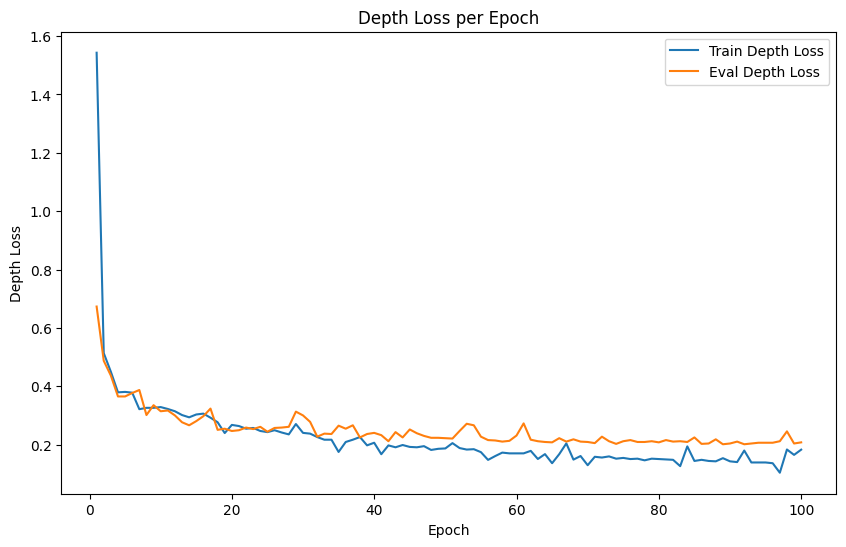

In [69]:
# Generate epoch numbers based on the parsed data
epochs = list(range(1, len(train_metrics['depth_losses']) + 1))

# Plot Depth Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_metrics['depth_losses'], label="Train Depth Loss")
plt.plot(epochs, valid_metrics['depth_losses'], label="Eval Depth Loss")
plt.xlabel("Epoch")
plt.ylabel("Depth Loss")
plt.legend()
plt.title("Depth Loss per Epoch")
plt.show()


In [70]:
loaded_model = torch.load("Depth_model_99",map_location=torch.device('cpu'))

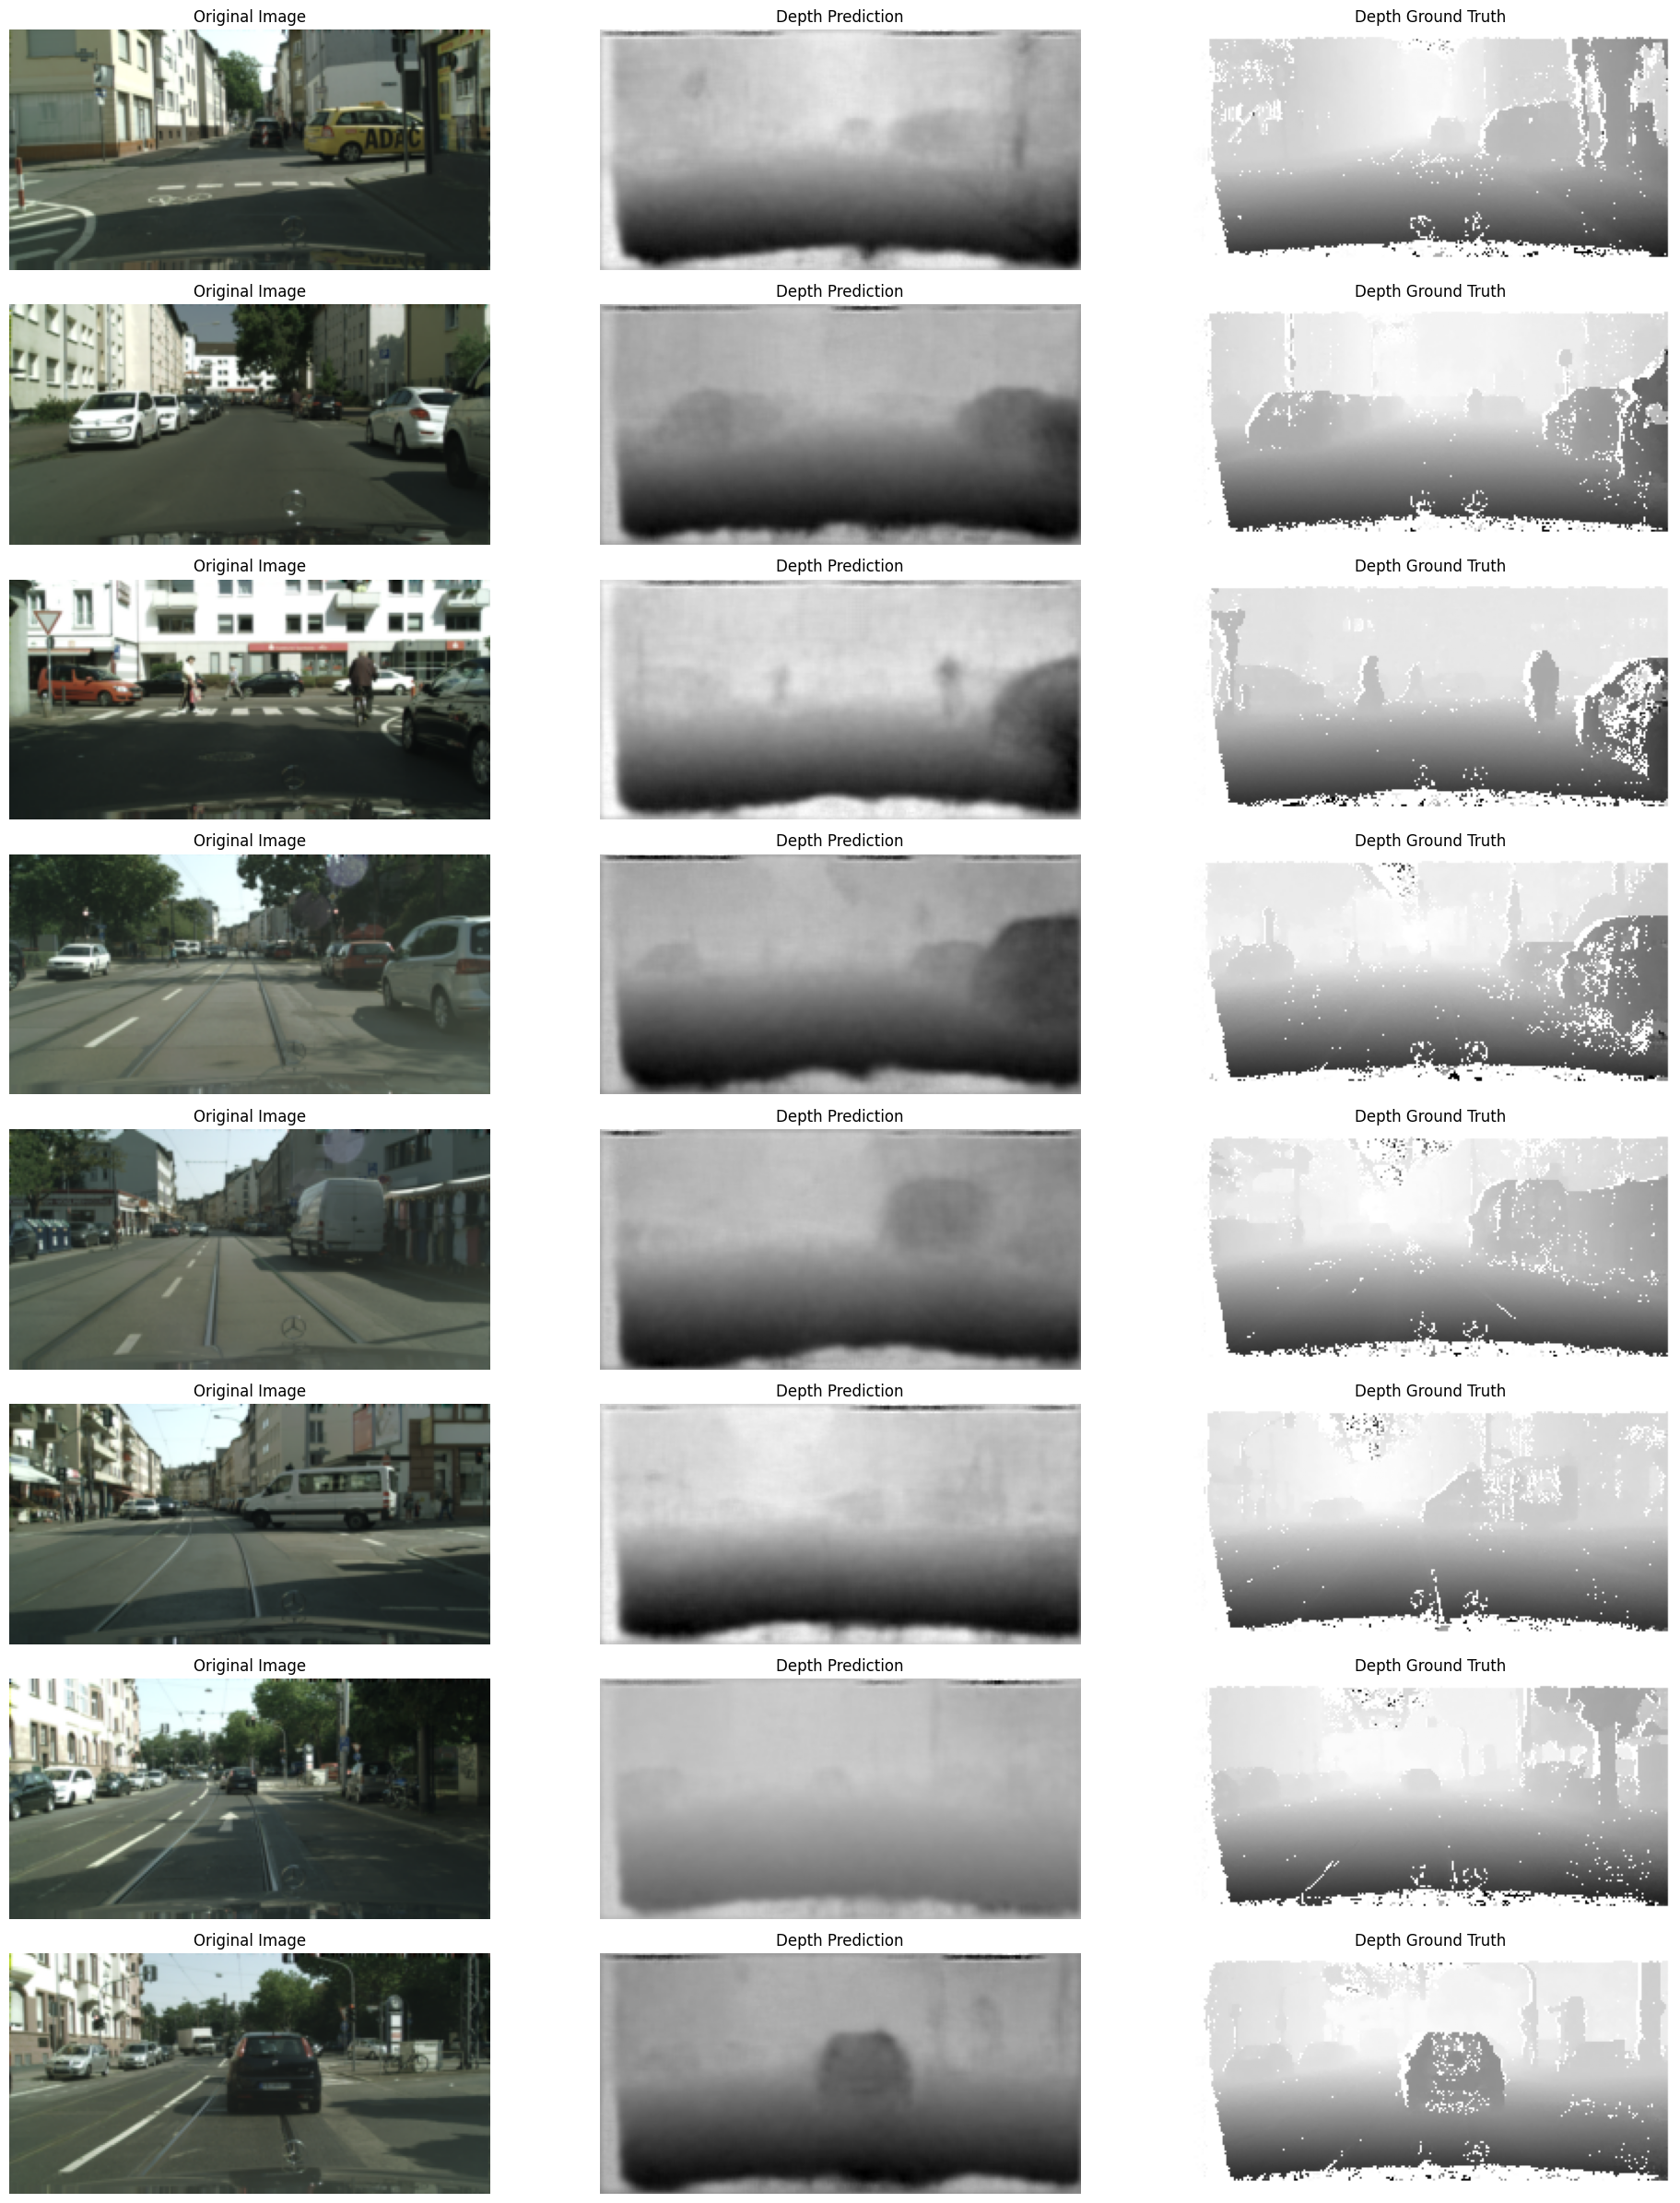

In [71]:
# Cityscapes class names and corresponding colors
CITYSCAPES_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 
    'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 
    'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle','unlabeled'
]

CITYSCAPES_COLORS = np.array([
    [0, 0, 0],         # road (black)
    [128, 64, 128],    # sidewalk (purple)
    [244, 35, 232],    # building (pinkish-purple)
    [70, 70, 70],      # wall (dark gray)
    [102, 102, 156],   # fence (gray-blue)
    [190, 153, 153],   # pole (pinkish-gray)
    [153, 153, 153],   # traffic light (light gray)
    [250, 170, 30],    # traffic sign (orange-yellow)
    [220, 220, 0],     # vegetation (yellow)
    [107, 142, 35],    # terrain (green)
    [152, 251, 152],   # sky (light green)
    [70, 130, 180],    # person (blue)
    [220, 20, 60],     # rider (red)
    [255, 0, 0],       # car (bright red)
    [0, 0, 142],       # truck (dark blue)
    [0, 0, 70],        # bus (dark navy blue)
    [0, 60, 100],      # train (teal)
    [0, 80, 100],      # motorcycle (blue-green)
    [0, 0, 230],       # bicycle (bright blue)
    [119, 11, 32]      # unlabeled (dark red)
], dtype=np.uint8)


def map_classes_to_colors(segmentation_output):
    """Map class indices to Cityscapes colors."""
    h, w = segmentation_output.shape
    colored_output = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(CITYSCAPES_COLORS):
        colored_output[segmentation_output == class_idx] = color
    return colored_output

def visualize_with_cityscapes_classes(images, depth_pred, depth_gt):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 3))
    
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(depth_pred[i].cpu().numpy(), cmap='binary')
        axes[i, 1].set_title('Depth Prediction')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(depth_gt[i].cpu().numpy(), cmap='binary')
        axes[i, 2].set_title('Depth Ground Truth')
        axes[i, 2].axis('off')
    
    
    plt.tight_layout()
    plt.show()

# Testing the updated visualization
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for i, batch in enumerate(test_loader):
        images = batch['image'].to(device)
        depth_gt = batch['depth'].to(device)
        
        # Model predictions
        output = loaded_model(images)
        depth_pred = output['depth'].squeeze()
        
        # Visualization with Cityscapes class mapping
        visualize_with_cityscapes_classes(images,depth_pred, depth_gt.squeeze())
        break
